In [1]:
import sys
import os
sys.path.append('..')

In [2]:
from workspace import nometools as nome

In [81]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pickle
import scipy
from scipy.stats import pearsonr

import threading
import multiprocessing 

In [4]:
main_path = '/home/kevin/DNA-Methylation-patterns/'
data_path = main_path + 'intron_reg/'
steric_path = main_path + 'intron_reg/steric_clash/'

In [5]:
np.random.seed(1234)

#### Promoter annotation and sorting

In [6]:
infile = data_path + 'refGene'

coords_track ={}
seen_coords = set()
itr = 0
with open(infile, 'r') as fin:
    for line in fin:
        if not line.startswith('#'):
            if itr > 100:
                break

            line_s = line.strip().split('\t')

            refid = line_s[1]
            chrom = line_s[2]
            strand = line_s[3]
            txStart = int(line_s[4])
            txEnd = int(line_s[5])
            cdsStart = int(line_s[6])
            cdsEnd = int(line_s[7])
            geneName = ''.join(c for c in line_s[12] if c.isalnum())

            coords = chrom + str(txStart) + str(txEnd) + strand
            if coords not in seen_coords:
                seen_coords.add(coords)
                coords_track[coords] = line_s

                if int(line_s[8]) < 1:
                    print(line_s[8])
                # promo_start = 2000
                # promo_end = 1000

                if strand == "+":
                    # promoter_start = txStart - promo_start
                    # promoter_end = txStart + promo_end
                    pass
                else:
                    pass
                    # promoter_start = txEnd - promo_end
                    # promoter_end = txEnd + promo_start
                
                # if promoter_start < 0:
                #         promoter_start = 0

                if cdsStart != cdsEnd and geneName[0:3] != 'MIR' and geneName[0:3] != 'SNO' and '_' not in chrom:
                    # fout.write('\t'.join([str(s) for s in [chrom, promoter_start, promoter_end, refid, geneName, txStart, txEnd, strand]]) + '\n')
                    itr += 1

            else:
                print(f'same coords {coords}')
                print(line_s)
                print(coords_track[coords])
                break 

same coords chr16699927567216822+
['0', 'NM_001308203', 'chr1', '+', '66999275', '67216822', '67000041', '67208778', '22', '66999275,66999928,67091529,67098752,67105459,67108492,67109226,67136677,67137626,67138963,67142686,67145360,67154830,67155872,67160121,67184976,67194946,67199430,67205017,67206340,67206954,67208755,', '66999355,67000051,67091593,67098777,67105516,67108547,67109402,67136702,67137678,67139049,67142779,67145435,67154958,67155999,67160187,67185088,67195102,67199563,67205220,67206405,67207119,67216822,', '0', 'SGIP1', 'cmpl', 'cmpl', '-1,0,1,2,0,0,1,0,1,2,1,1,1,0,1,1,2,2,0,2,1,1,']
['0', 'NM_001376542', 'chr1', '+', '66999275', '67216822', '67000041', '67208778', '25', '66999275,66999928,67091529,67098752,67105459,67108492,67109226,67126195,67133212,67136677,67137626,67138963,67142686,67145360,67147551,67154830,67155872,67161116,67184976,67194946,67199430,67205017,67206340,67206954,67208755,', '66999620,67000051,67091593,67098777,67105516,67108547,67109402,67126207,671

In [7]:
def get_introns_refGene(infile, outfile):
    seen_coords = set()
    itr = 0
    with open(outfile, 'w') as fout:
        with open(infile, 'r') as fin:
            for line in fin:
                if not line.startswith('#'):
                    line_s = line.strip().split('\t')

                    refid = line_s[1]
                    chrom = line_s[2]
                    strand = line_s[3]
                    txStart = int(line_s[4])
                    txEnd = int(line_s[5])
                    cdsStart = int(line_s[6])
                    cdsEnd = int(line_s[7])
                    geneName = ''.join(c for c in line_s[12] if c.isalnum())

                    coords = chrom + str(txStart) + str(txEnd) + strand
                    if coords not in seen_coords:
                        seen_coords.add(coords)

                        if cdsStart != cdsEnd and geneName[0:3] != 'MIR' and geneName[0:3] != 'SNO' and '_' not in chrom:
                            assert line_s[9].endswith(',')
                            assert line_s[10].endswith(',')

                            exon_starts = np.array(list(map(int, line_s[9][:-1].strip().split(','))))
                            exon_ends = np.array(list(map(int, line_s[10][:-1].strip().split(','))))

                            assert exon_starts.shape == exon_ends.shape

                            intron_starts = exon_ends[:-1].copy()
                            intron_ends = exon_starts[1:].copy()

                            assert np.all((intron_ends - intron_starts) >= 0)

                            for start, end in zip(intron_starts, intron_ends):
                                if end > start:
                                    fout.write('\t'.join([str(s) for s in [chrom, start, end, refid, geneName, txStart, txEnd, strand]]) + '\n')
                                    itr += 1

                                break

    print('no of introns defined :', itr)
    print('introns saved to {}'.format(outfile))

In [8]:
# # Getting introns from refGene

# infile = data_path + 'refGene'
# outfile = data_path + 'refGene.introns.bed'
# get_introns_refGene(infile, outfile)                     

In [9]:
outfile = data_path + 'refGene.introns.bed'
print('no of introns :', nome.get_num_reads(outfile))

no of introns : 31070


In [10]:
# # sorting bed files introns

# infile = data_path + 'refGene.introns.window_20000.bed'
# outfile = data_path + 'refGene.introns.window_20000.sorted.bed'

# nome.sort_bed(infile, outfile)

In [11]:
## checking length of intron regions

infile = data_path + 'refGene.introns.bed'
temp = []
with open(infile, 'r') as fin:
    for line in fin:
        line_s = line.strip().split('\t')
        chrom = line_s[0]
        strand = line_s[-1]
        i_start = int(line_s[1])
        i_end = int(line_s[2])

        temp.append([chrom, i_start, i_end, strand])

df_introns = pd.DataFrame(temp, columns=['chr', 'start', 'end', 'strand'])

In [12]:
df_introns.head()

,chr,start,end,strand
0,chr1,66999620,66999928,+
1,chr1,66999090,66999928,+
2,chr1,67000051,67091529,+
3,chr1,67000051,67091529,+
4,chr1,16767348,16770126,+


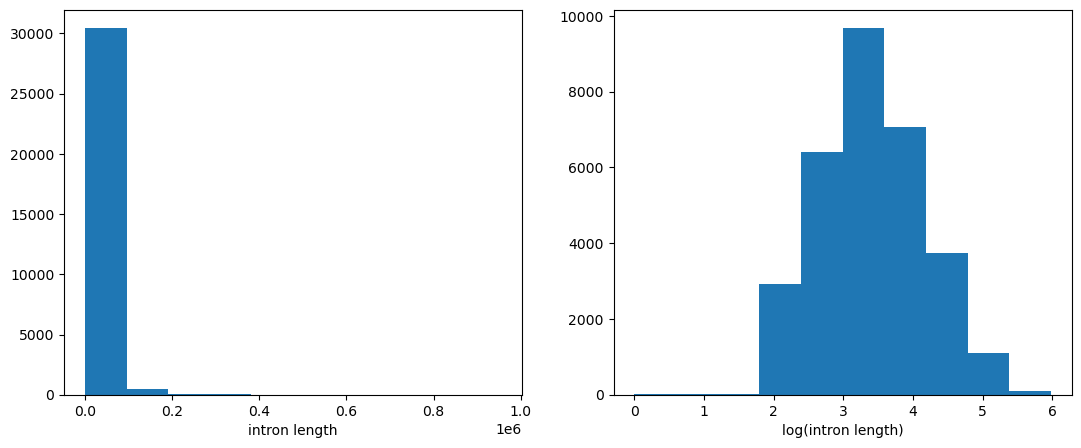

In [13]:
reg_len = df_introns['end'] - df_introns['start'] 
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist(reg_len)
plt.xlabel('intron length')
plt.subplot(1,2,2)
plt.hist(np.log10(reg_len))
plt.xlabel('log(intron length)')
plt.show()

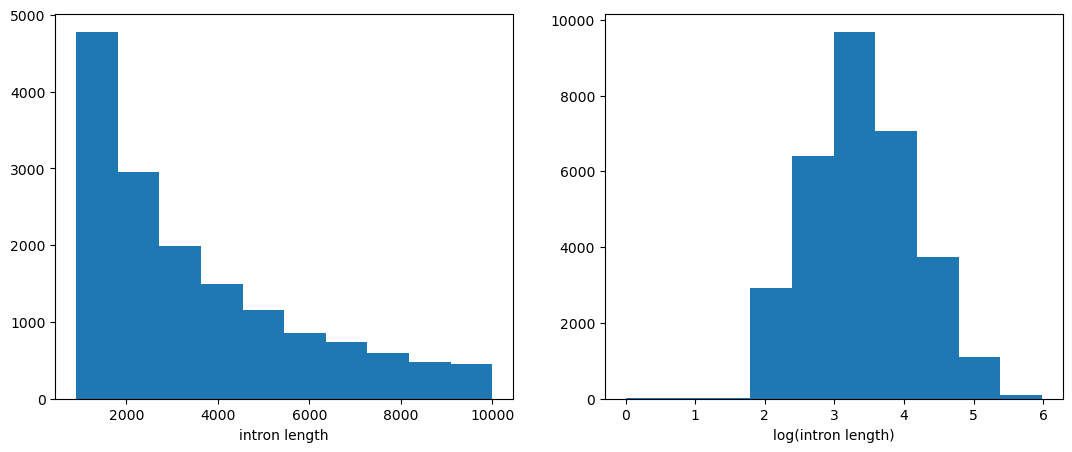

In [14]:
reg_len = df_introns['end'] - df_introns['start'] 
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist(reg_len[np.all(pd.concat([reg_len > 900, reg_len < 10000], axis=1), axis=1)])
plt.xlabel('intron length')
plt.subplot(1,2,2)
plt.hist(np.log10(reg_len))
plt.xlabel('log(intron length)')
plt.show()

#### GCH filtering and intersection

In [15]:
# # Filtering GCH file
# # Filtering for reads with coverage >= 3

# infile = data_path + 'cpg.raw.sort.GCH.bed'
# outfile = data_path + 'GCH.filtered.bed'

# nome.filter_bed_files(infile, outfile)

In [16]:
# infile = data_path + 'cpg.raw.sort.GCH.bed'
# outfile = data_path + 'GCH.filtered.bed'
# ni = nome.get_num_reads(infile)
# no = nome.get_num_reads(outfile)
# print('no of reads in GCH file :', ni)
# print('no of reads in filtered GCH file :', no)
# print('percentage of reads remaining {}%'.format(round(no*100/ni, 2)))

In [17]:
## sorting bed files GCH

# infile = data_path + 'GCH.filtered.bed'
# outfile = data_path + 'GCH.filtered.sorted.bed'

# nome.sort_bed(infile, outfile)

In [18]:
# # GCH intersect with introns

# introns_sorted = data_path + 'refGene.introns.window_20000.sorted.bed'
# gch_sorted = data_path + 'GCH.filtered.sorted.bed'
# outfile = data_path + 'GCH.introns.window_20000.intersect.bed'

# nome.intersect_bed(introns_sorted, gch_sorted, outfile)

In [19]:
outfile = data_path + 'GCH.introns.anchor_start.intersect.bed'
print('no of reads in introns region :', nome.get_num_reads(outfile))

no of reads in introns region : 2983082


In [20]:
outfile = data_path + 'refGene.introns.anchor_start.sorted.bed'
print('no of introns :', nome.get_num_reads(outfile))

no of introns : 31070


In [156]:
def get_intron_methylation(infile):
    inter_dict = dict()
    seen_ids = set()

    with open(infile) as f:
        for line in f:
            line_s = line.strip().split('\t')

            chrom = line_s[0]            
            intron_start = int(line_s[1])
            intron_end = int(line_s[2])
            refid = line_s[3]
            gene_name = line_s[4]
            TSS = int(line_s[5])
            TES = int(line_s[6])
            strand = line_s[7]
            meth_start = int(line_s[9])
            meth_end = int(line_s[10])
            meth_rate = float(line_s[12])
            coverage = int(line_s[13])

            dict_id = refid + "-" + str(intron_start)
            
            ## We are checking + and -ve strands based on promoter
            if strand == "+":
                intron_abs_pos = meth_start - intron_start
            if strand == "-":
                intron_abs_pos = intron_end - meth_end
        
            rel_pos = intron_abs_pos - 2000
        
            if dict_id not in seen_ids:
                seen_ids.add(dict_id)
                inter_dict[dict_id] = dict()
            
            inter_dict[dict_id][meth_start] = dict()
            
            inter_dict[dict_id][meth_start]["chrom"] = chrom
            inter_dict[dict_id][meth_start]["intron_start"] = intron_start
            inter_dict[dict_id][meth_start]["intron_end"] = intron_end
            inter_dict[dict_id][meth_start]["gene_name"] = gene_name
            inter_dict[dict_id][meth_start]["TSS"] = TSS
            inter_dict[dict_id][meth_start]["TES"] = TES
            inter_dict[dict_id][meth_start]["strand"] = strand
            
            inter_dict[dict_id][meth_start]["meth_start_genome"] = meth_start
            inter_dict[dict_id][meth_start]["meth_end_genome"] = meth_end
            inter_dict[dict_id][meth_start]["meth_pos_intron_abs"] = intron_abs_pos
            inter_dict[dict_id][meth_start]["meth_pos_intron_rel"] = rel_pos
                        
            inter_dict[dict_id][meth_start]["meth_rate"] = meth_rate
            inter_dict[dict_id][meth_start]["coverage"] = coverage

    column_names = ['trans_id', 'refid', 'gene_name', 'chrom', 'intron_start', 'intron_end', 
                    'TSS', 'TES', 'strand', 'meth_start_genome', 'meth_end_genome', 'meth_pos_intron_abs', 'meth_pos_intron_rel', 'meth_rate', 'coverage']

    info_dict = dict()
    for col in column_names:
        info_dict[col] = []

    ## Can create a filter for no of GCH or HCG in a promoter
    for dict_id in inter_dict.keys():
        refid = dict_id.split("-")[0]
        for promo_start in inter_dict[dict_id].keys():
            info_dict["trans_id"].append(dict_id)
            info_dict["refid"].append(refid)
            info_dict["gene_name"].append(inter_dict[dict_id][promo_start]["gene_name"])
            info_dict["chrom"].append(inter_dict[dict_id][promo_start]["chrom"])
            info_dict["intron_start"].append(inter_dict[dict_id][promo_start]["intron_start"])
            info_dict["intron_end"].append(inter_dict[dict_id][promo_start]["intron_end"])
            info_dict["TSS"].append(inter_dict[dict_id][promo_start]["TSS"])
            info_dict["TES"].append(inter_dict[dict_id][promo_start]["TES"])
            info_dict["strand"].append(inter_dict[dict_id][promo_start]["strand"])
            
            info_dict["meth_start_genome"].append(inter_dict[dict_id][promo_start]["meth_start_genome"])
            info_dict["meth_end_genome"].append(inter_dict[dict_id][promo_start]["meth_end_genome"])
            info_dict["meth_pos_intron_abs"].append(inter_dict[dict_id][promo_start]["meth_pos_intron_abs"])
            info_dict["meth_pos_intron_rel"].append(inter_dict[dict_id][promo_start]["meth_pos_intron_rel"])
            
            info_dict["meth_rate"].append(inter_dict[dict_id][promo_start]["meth_rate"])
            info_dict["coverage"].append(inter_dict[dict_id][promo_start]["coverage"])

    # Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["refid"])), columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]  
        
    df = df.sort_values(by = ['chrom', 'intron_start'], ascending = [True, True])

    return df

In [ ]:
infile = data_path + 'GCH.introns.anchor_start.intersect.bed'
df = get_intron_methylation(infile)

In [22]:
df.head()

,trans_id,refid,gene_name,chrom,intron_start,intron_end,TSS,TES,strand,meth_start_genome,meth_end_genome,meth_pos_intron_abs,meth_pos_intron_rel,meth_rate,coverage
0,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858555,858556,227,-1773,0.00,3
1,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858564,858565,236,-1764,0.00,3
2,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858595,858596,267,-1733,0.00,3
3,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858600,858601,272,-1728,33.33,3
4,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858735,858736,407,-1593,50.00,4


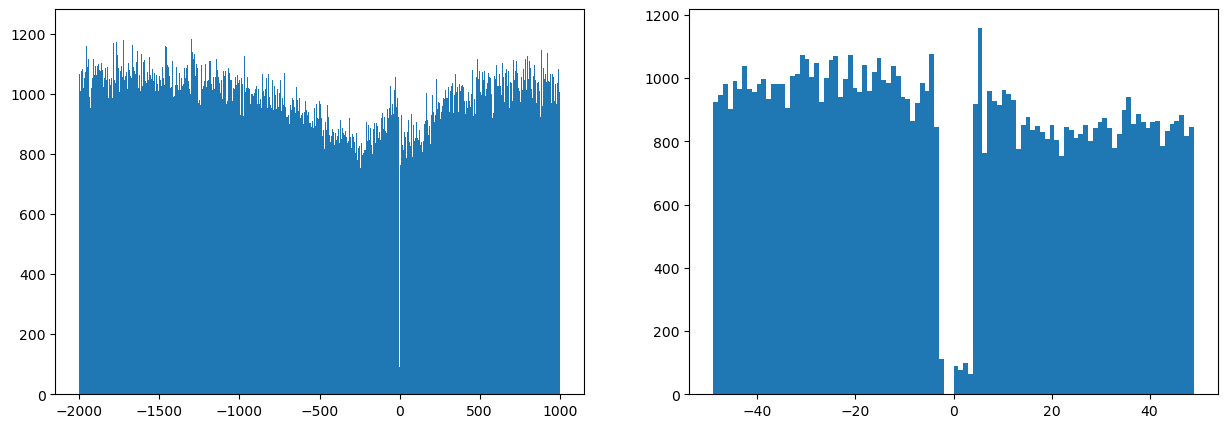

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(df['meth_pos_intron_rel'], bins=3000)
plt.subplot(1,2,2)
plt.hist(df['meth_pos_intron_rel'][np.all(pd.concat((df['meth_pos_intron_rel'] > -50, df['meth_pos_intron_rel'] < 50), axis=1), axis=1)], bins=100)
plt.show()

In [24]:
df.shape

(2973620, 15)

In [25]:
print('no of introns : ', df['trans_id'].unique().shape)

no of introns :  (30511,)


In [101]:
print('no of introns : ', df['gene_name'].unique().shape)

no of introns :  (17643,)


In [100]:
temp = pd.read_csv(data_path + 'refGene.introns.bed', sep='\t', header=None, names=['chr',	'intron_start',	'intron_end', 'trans_id',
                                                                                     'gene_name', 'TSS', 'TES', 'strand'])
print('no of introns : ', df['gene_name'].unique().shape)

no of introns :  (17643,)


In [149]:
def plot_avg_methylation_levels(df, context, select_genes=[], fig = True, c = 'grey', label = None, rel=False, inter_start=None, inter_end=None):
    
    if len(select_genes) == 0: 
        all_meth_pos_promo_rel = list(df['meth_pos_intron_rel'])
        all_meth_rate = list(df['meth_rate'])
        all_coverage = list(df['coverage'])

        assert len(all_meth_pos_promo_rel) == len(all_meth_rate) == len(all_coverage)

        av_dict = dict()
        seen_pos = set()
        for p in range(len(all_meth_pos_promo_rel)):
            rel_pos_x = all_meth_pos_promo_rel[p]
            meth_rate = all_meth_rate[p]
            coverage = all_coverage[p]
            
            #AVERAGE
            if rel_pos_x not in seen_pos:
                seen_pos.add(rel_pos_x)
                av_dict[rel_pos_x] = {}
                av_dict[rel_pos_x]['meth'] = []
                av_dict[rel_pos_x]['total'] = []
            
            if context == 'GCH':
                av_dict[rel_pos_x]['meth'].append(coverage*(100-meth_rate)/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            elif context == 'HCG':
                av_dict[rel_pos_x]['meth'].append(meth_rate*coverage/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            else:
                print('Check context')
                return
    else:
        av_dict = {}
        seen_pos = set()
        # group = df[df['refid'].isin(select_genes)]
        group = df[df['gene_name'].isin(select_genes)]
        for rel_pos_x, meth_rate, coverage in zip(group['meth_pos_intron_rel'], group['meth_rate'], group['coverage']):
            if rel_pos_x not in seen_pos:
                seen_pos.add(rel_pos_x)
                av_dict[rel_pos_x] = {}
                av_dict[rel_pos_x]['meth'] = []
                av_dict[rel_pos_x]['total'] = []

            if context == 'GCH':
                av_dict[rel_pos_x]['meth'].append(coverage*(100-meth_rate)/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            elif context == 'HCG':
                av_dict[rel_pos_x]['meth'].append(meth_rate*coverage/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            else:
                print('Check context')
                return
            

    if fig:
        plt.figure(figsize=(15, 7), facecolor='w', edgecolor='k')

    x = []
    y = []

    for rel_pos_x in sorted(av_dict.keys()):
        if rel:
            if rel_pos_x >= inter_start and rel_pos_x <= inter_end:
                if len(av_dict[rel_pos_x]['meth']) >= 3:
                    x.append(rel_pos_x)
                    y.append(np.sum(av_dict[rel_pos_x]['meth'])*100/np.sum(av_dict[rel_pos_x]['total']))
        else:
            if len(av_dict[rel_pos_x]['meth']) >= 3:
                x.append(rel_pos_x)
                y.append(np.sum(av_dict[rel_pos_x]['meth'])*100/np.sum(av_dict[rel_pos_x]['total']))

    if label is None:
        plt.plot(x, y, "-", color=c, alpha=1.0)
    else:
        plt.plot(x, y, "-", color=c, label=label, alpha=0.7)
        plt.legend()
        
    plt.xlabel("DNA position [bp]")

    if context == 'GCH':
        ylab = "100-GpC methylation level"
    if context == 'HCG':
        ylab = "CpG methylation level"
    plt.ylabel(ylab)

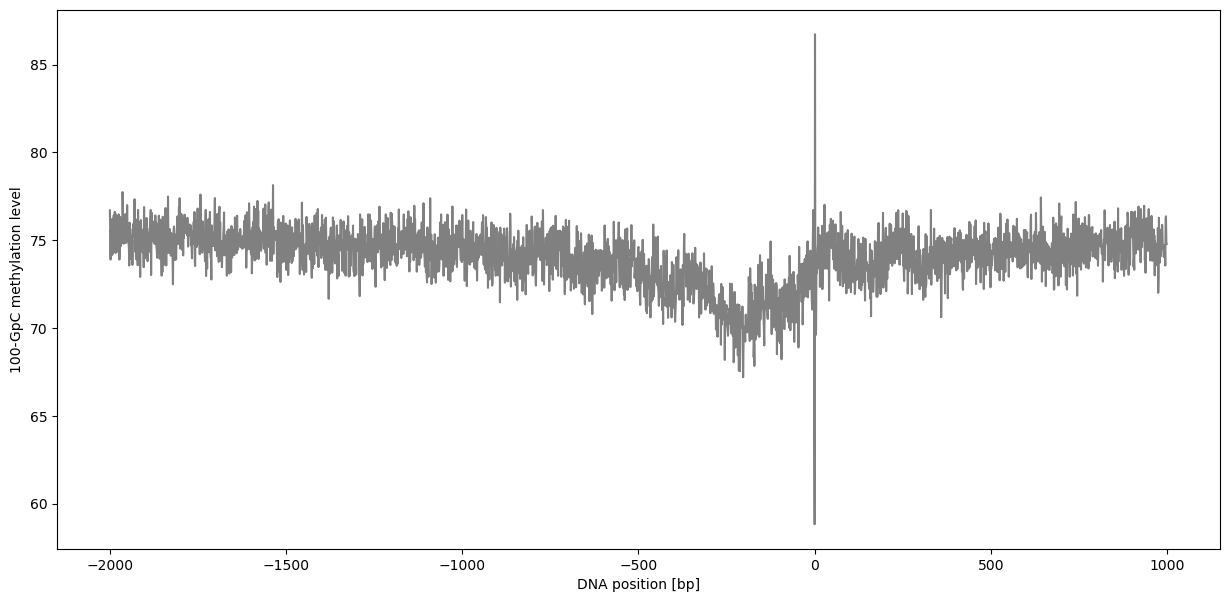

In [103]:
plot_avg_methylation_levels(df, 'GCH')

In [104]:
# plot_avg_methylation_levels(df, 'GCH', rel=True, inter_start=0, inter_end=1000)

In [105]:
df.head()

,trans_id,refid,gene_name,chrom,intron_start,intron_end,TSS,TES,strand,meth_start_genome,meth_end_genome,meth_pos_intron_abs,meth_pos_intron_rel,meth_rate,coverage
0,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858555,858556,227,-1773,0.00,3
1,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858564,858565,236,-1764,0.00,3
2,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858595,858596,267,-1733,0.00,3
3,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858600,858601,272,-1728,33.33,3
4,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858735,858736,407,-1593,50.00,4


In [106]:
print('no of introns : ', df['gene_name'].unique().shape)

no of introns :  (17643,)


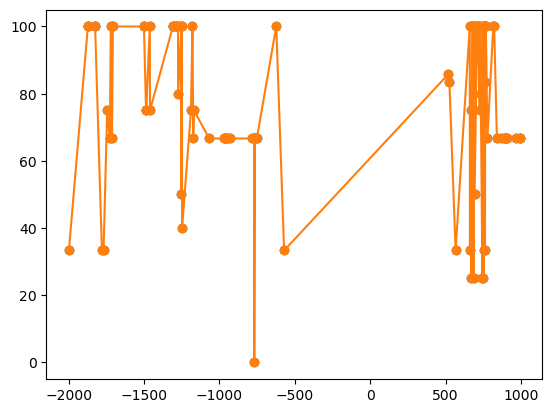

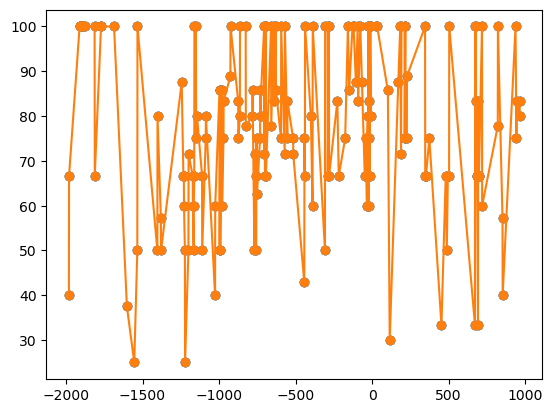

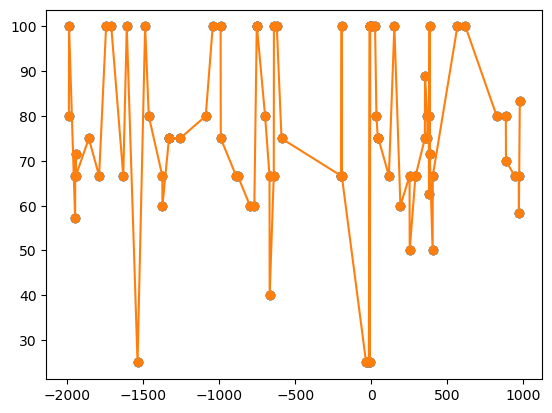

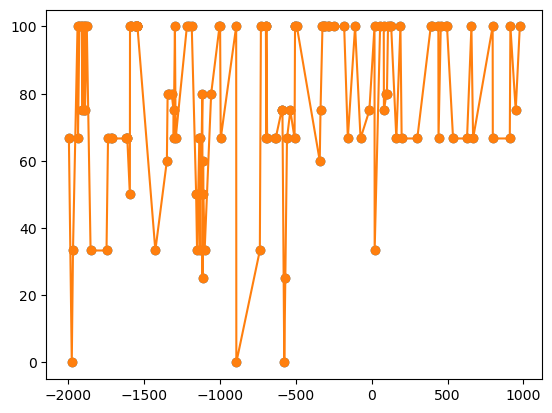

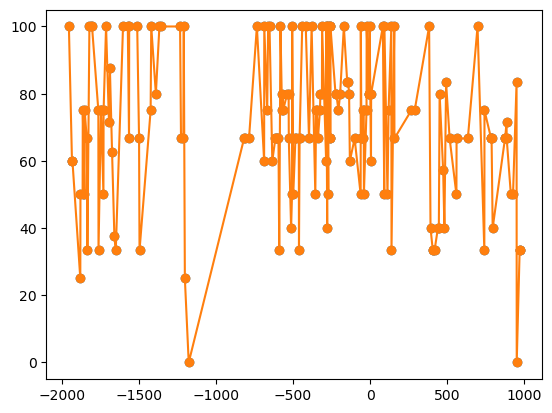

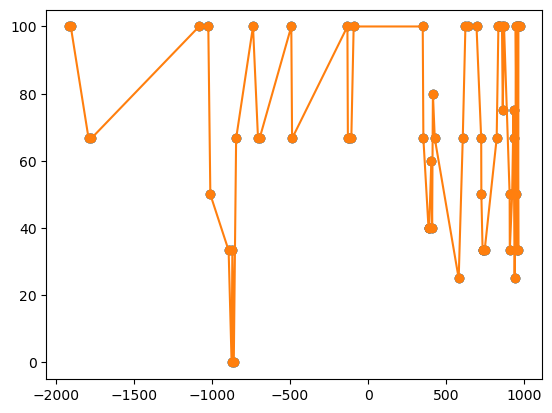

In [79]:
gene_groups = df.groupby('gene_name')


for i, (name, group) in enumerate(gene_groups):
    plt.figure()
    plt.plot(group['meth_pos_intron_rel'], 100-group['meth_rate'], 'o')

    pdata = {}
    for rel, rate, cov in zip(group['meth_pos_intron_rel'], group['meth_rate'], group['coverage']):
        if rel not in pdata:
            pdata[rel] = []
            pdata[rel].append(100-rate)
        else:
            pdata[rel].append(100-rate)

    x = []
    y = []
    for rel_pos_x in sorted(pdata.keys()):
        if rel_pos_x >= -2000 and rel_pos_x <= 1000:
            x.append(rel_pos_x)
            y.append(np.mean(pdata[rel_pos_x]))
    
    plt.plot(x, y, 'o-')
    
    if i==5:
        break

18 0.04601426413349472 0.2750773041127842 1.8147324372254939e-10 502


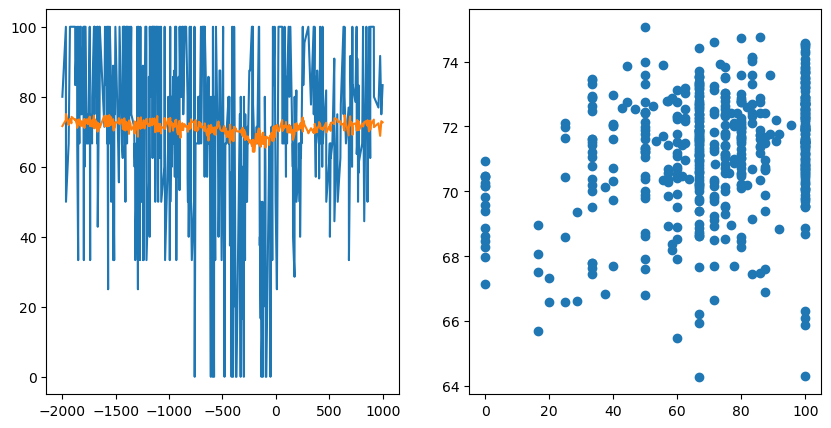

28 0.01826597741497727 0.10401555639914002 0.00845535066505198 527


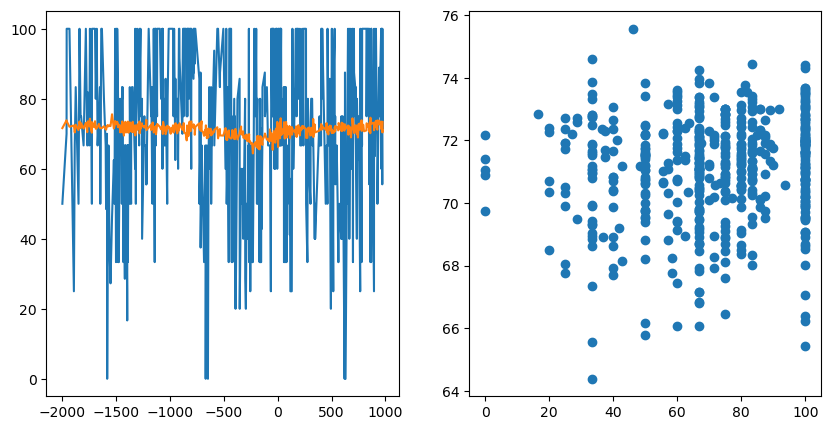

50 0.011178931134738192 0.22217200222085637 0.0030555325836805415 151


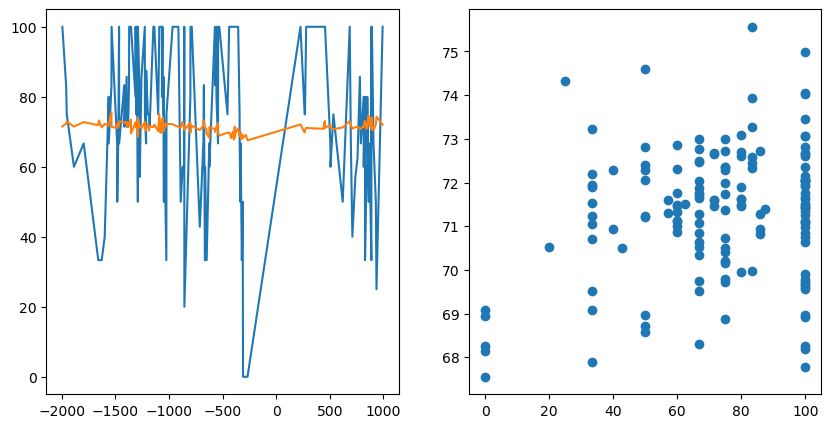

51 0.012326142494424876 0.12289286918860151 0.016531167912809872 301


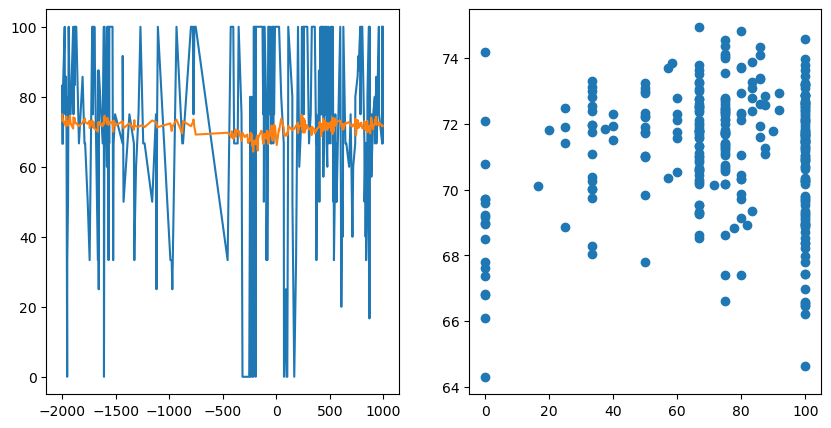

72 0.016024118589834897 0.28795437058739237 8.049172907427542e-05 167


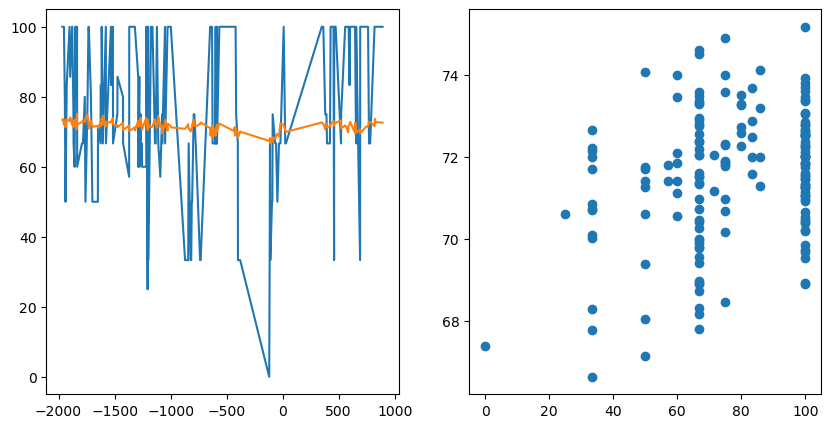

73 0.024654722788839057 0.5067727608856576 3.363292460222517e-11 146


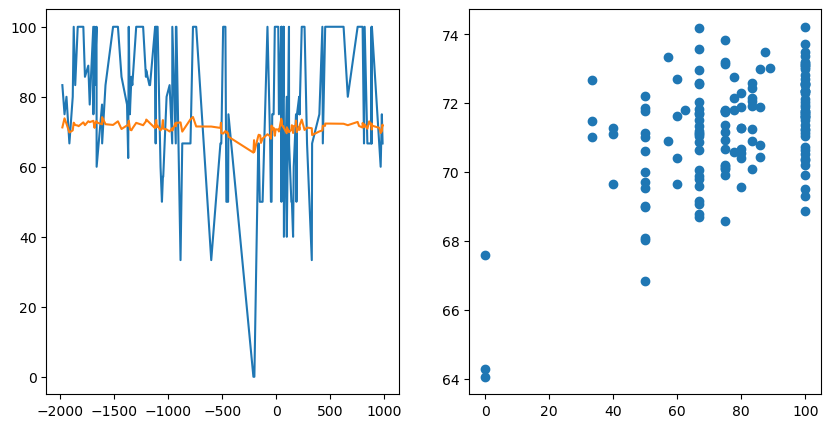

87 0.015791222950165638 0.38217306510844423 5.932627458471231e-06 124


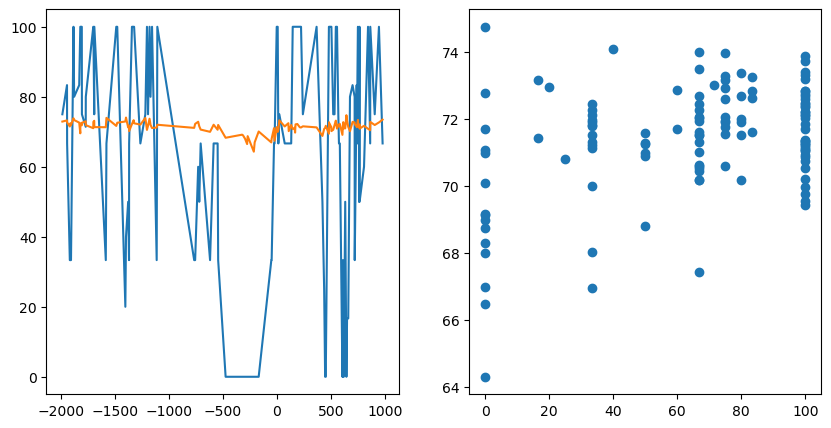

89 0.029425124767960695 0.3098414015040352 4.654606433168064e-08 285


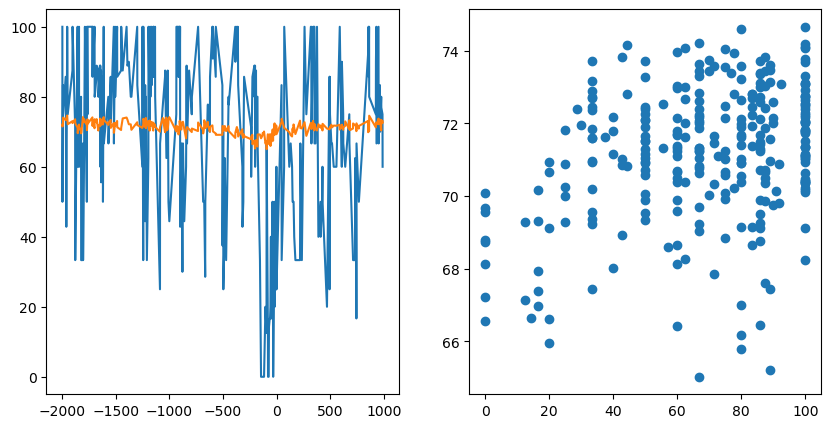

95 0.012399847088158835 0.20673300617535925 0.002681048229332119 180


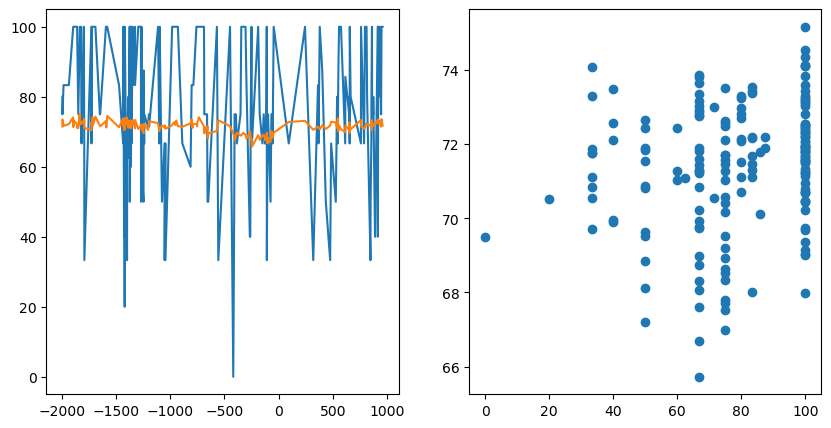

96 0.013926587039543114 0.15197704620243233 0.005810489711158449 275


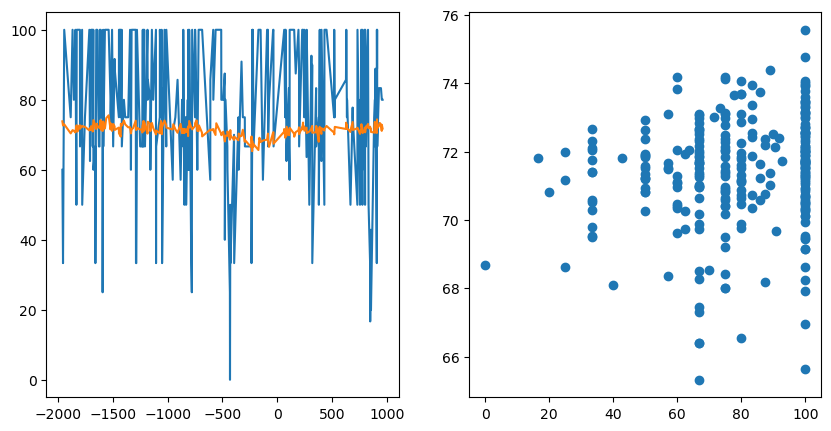

113 0.010176907096056904 0.28812168108742237 0.001372199912935547 106


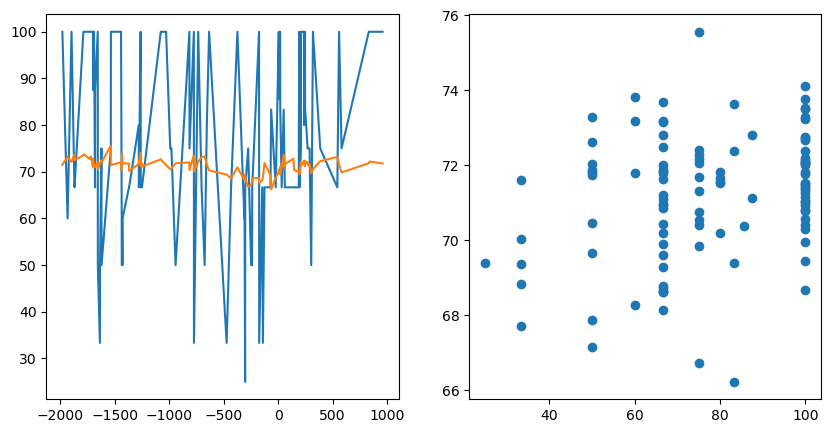

In [84]:
context = 'GCH'
av_dict = dict()
seen_pos = set()
for i, (rel_pos_x, meth_rate, coverage) in enumerate(zip(df['meth_pos_intron_rel'], df['meth_rate'], df['coverage'])):
    if rel_pos_x not in seen_pos:
        seen_pos.add(rel_pos_x)
        av_dict[rel_pos_x] = {}
        av_dict[rel_pos_x]['meth'] = []
        av_dict[rel_pos_x]['total'] = []
    
    if context == 'GCH':
        av_dict[rel_pos_x]['meth'].append(int(coverage*(100-meth_rate)/100))
        av_dict[rel_pos_x]['total'].append(coverage)
    elif context == 'HCG':
        av_dict[rel_pos_x]['meth'].append(meth_rate*coverage)
        av_dict[rel_pos_x]['total'].append(coverage)
    else:
        print('Check context')
    
x = []
y = []

for rel_pos_x in sorted(av_dict.keys()):
    if rel_pos_x >= -2000 and rel_pos_x <= 1000:
        x.append(rel_pos_x)
        y.append(np.sum(av_dict[rel_pos_x]['meth'])*100/np.sum(av_dict[rel_pos_x]['total']))


gch_meth = np.ones(3001) * np.inf
mask = np.zeros(3001, dtype=bool)
mask[np.array(x) + 2000] = True
gch_meth[np.array(x) + 2000] = np.array(y)

gene_groups = df.groupby('gene_name')
counter = 0
gene_corr = {}
for i, (name, group) in enumerate(gene_groups):
    pdata = {}
    for rel, rate, cov in zip(group['meth_pos_intron_rel'], group['meth_rate'], group['coverage']):
        if rel not in pdata:
            pdata[rel] = []
            pdata[rel].append(100-rate)
        else:
            pdata[rel].append(100-rate)

    x = []
    y = []
    for rel_pos_x in sorted(pdata.keys()):
        if rel_pos_x >= -2000 and rel_pos_x <= 1000:
            x.append(rel_pos_x)
            y.append(np.mean(pdata[rel_pos_x]))

    if len(x) < 3:
        ## min one deg of freedom
        continue
    
    gene_corr[name] = {}

    gch_meth_gene = np.ones(3001) * np.inf
    mask_gene = np.zeros(3001, dtype=bool)
    mask_gene[np.array(x) + 2000] = True
    gch_meth_gene[np.array(x) + 2000] = np.array(y)

    # corr = np.corrcoef(gch_meth_gene[mask_gene], gch_meth[mask_gene])[0][1]
    # weighted_coor = corr*np.sum(mask_gene)/mask_gene.shape[0]

    corr, p_value = pearsonr(gch_meth_gene[mask_gene], gch_meth[mask_gene], alternative='greater')
    weighted_coor = corr*np.sum(mask_gene)/mask_gene.shape[0]

    assert corr - np.corrcoef(gch_meth_gene[mask_gene], gch_meth[mask_gene])[0][1] < 1e-3

    gene_corr[name]['corr'] = corr
    gene_corr[name]['n'] = np.sum(mask_gene)
    gene_corr[name]['weighted_corr'] = weighted_coor

    if weighted_coor > 0.01:
        counter += 1
        print(i, weighted_coor, corr, p_value, np.sum(mask_gene))
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.plot(x, gch_meth_gene[mask_gene])
        plt.plot(x, gch_meth[mask_gene])
        plt.subplot(1,2,2)
        plt.scatter(gch_meth_gene[mask_gene], gch_meth[mask_gene])
        plt.show()

        if counter > 5:
            break
    

In [51]:
df.head()

,trans_id,refid,gene_name,chrom,intron_start,intron_end,TSS,TES,strand,meth_start_genome,meth_end_genome,meth_pos_intron_abs,meth_pos_intron_rel,meth_rate,coverage
0,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858555,858556,227,-1773,0.00,3
1,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858564,858565,236,-1764,0.00,3
2,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858595,858596,267,-1733,0.00,3
3,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858600,858601,272,-1728,33.33,3
4,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858735,858736,407,-1593,50.00,4


In [110]:
context = 'GCH'
av_dict = dict()
seen_pos = set()
for i, (rel_pos_x, meth_rate, coverage) in enumerate(zip(df['meth_pos_intron_rel'], df['meth_rate'], df['coverage'])):
    if rel_pos_x not in seen_pos:
        seen_pos.add(rel_pos_x)
        av_dict[rel_pos_x] = {}
        av_dict[rel_pos_x]['meth'] = []
        av_dict[rel_pos_x]['total'] = []
    
    if context == 'GCH':
        av_dict[rel_pos_x]['meth'].append(int(coverage*(100-meth_rate)/100))
        av_dict[rel_pos_x]['total'].append(coverage)
    elif context == 'HCG':
        av_dict[rel_pos_x]['meth'].append(meth_rate*coverage)
        av_dict[rel_pos_x]['total'].append(coverage)
    else:
        print('Check context')
    
x = []
y = []

for rel_pos_x in sorted(av_dict.keys()):
    if rel_pos_x >= -2000 and rel_pos_x <= 1000:
        x.append(rel_pos_x)
        y.append(np.sum(av_dict[rel_pos_x]['meth'])*100/np.sum(av_dict[rel_pos_x]['total']))

gch_meth = np.ones(3001) * np.inf
mask = np.zeros(3001, dtype=bool)
mask[np.array(x) + 2000] = True
gch_meth[np.array(x) + 2000] = np.array(y)

gene_groups = df.groupby('gene_name')
counter = 0
gene_corr = {}
for i, (name, group) in enumerate(gene_groups):
    
    # if len(group['TSS'].unique()) > 4:
    #     print(group)
    #     print('gene name = ', name)
    #     print(group['refid'].unique())
    #     print(group[['refid', 'intron_start', 'intron_end']].drop_duplicates())
    #     break

    pdata = {}
    for rel, rate, cov in zip(group['meth_pos_intron_rel'], group['meth_rate'], group['coverage']):
        if rel not in pdata:
            pdata[rel] = []
            pdata[rel].append(100-rate)
        else:
            pdata[rel].append(100-rate)

    x = []
    y = []
    for rel_pos_x in sorted(pdata.keys()):
        if rel_pos_x >= -2000 and rel_pos_x <= 1000:
            x.append(rel_pos_x)
            y.append(np.mean(pdata[rel_pos_x]))

    if len(x) < 3:
        ## min one deg of freedom
        continue
    
    gene_corr[name] = {}

    gch_meth_gene = np.ones(3001) * np.inf
    mask_gene = np.zeros(3001, dtype=bool)
    mask_gene[np.array(x) + 2000] = True
    gch_meth_gene[np.array(x) + 2000] = np.array(y)

    corr, p_value = pearsonr(gch_meth_gene[mask_gene], gch_meth[mask_gene], alternative='greater')
    weighted_coor = corr*np.sum(mask_gene)/mask_gene.shape[0]

    gene_corr[name]['corr'] = corr
    gene_corr[name]['n'] = np.sum(mask_gene)
    gene_corr[name]['weighted_corr'] = weighted_coor    
    gene_corr[name]['p_value'] = p_value

/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [114]:
n_tests = len(gene_corr)
for gene in gene_corr:
    gene_corr[gene]['corrected_p_value'] = n_tests*gene_corr[gene]['p_value']

Distribution of correlation and p values

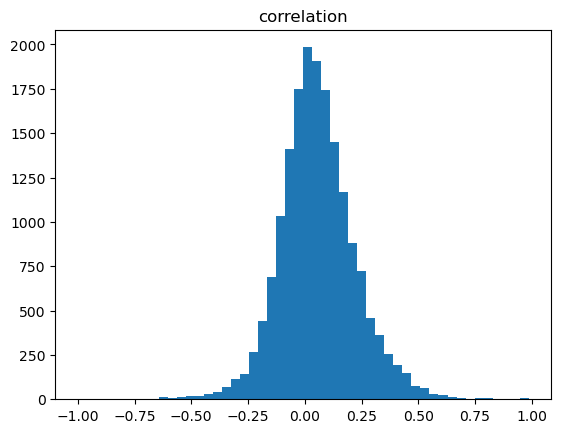

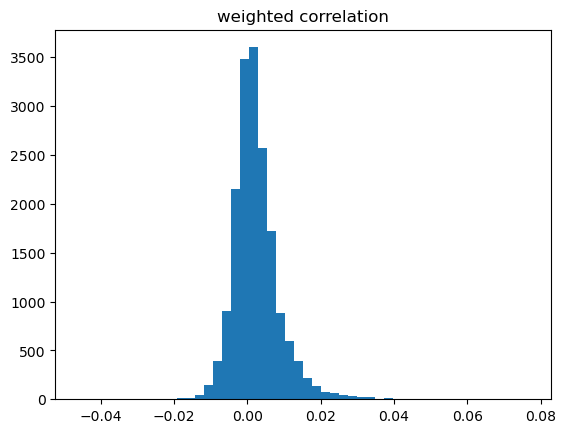

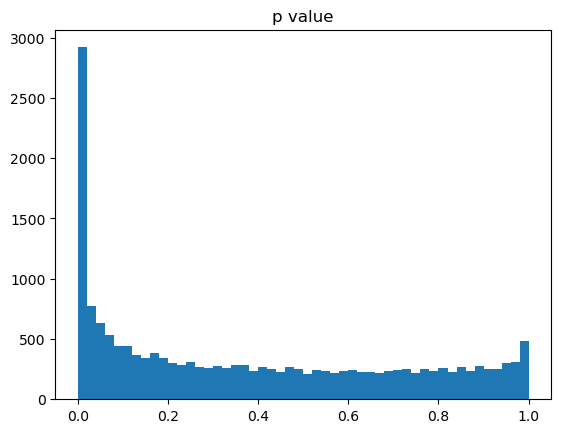

In [113]:
x = []
for key in gene_corr:
    x.append(gene_corr[key]['corr'])

plt.title('correlation')
plt.hist(x, bins=50)
plt.show()

x = []
for key in gene_corr:
    x.append(gene_corr[key]['weighted_corr'])

plt.title('weighted correlation')
plt.hist(x, bins=50)
plt.show()

x = []
for key in gene_corr:
    x.append(gene_corr[key]['p_value'])

plt.title('p value')
plt.hist(x, bins=50)
plt.show()

# selected genes = 1764


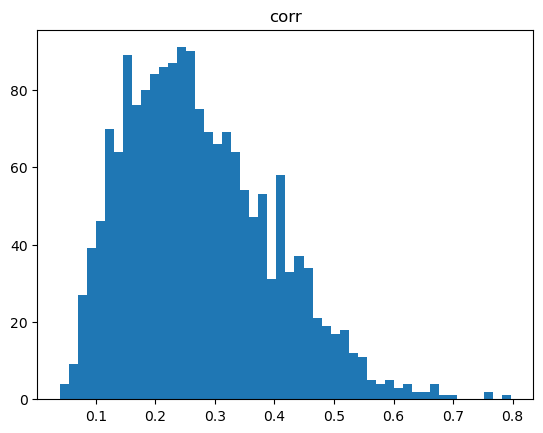

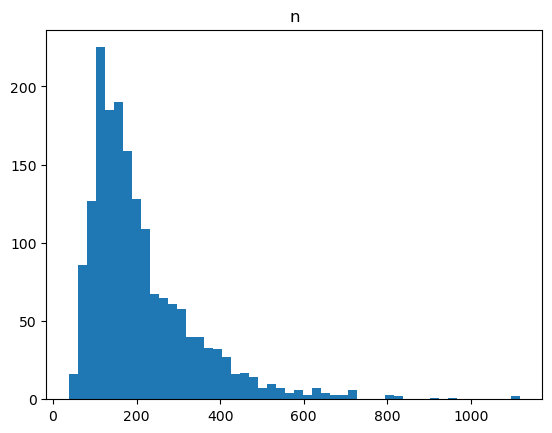

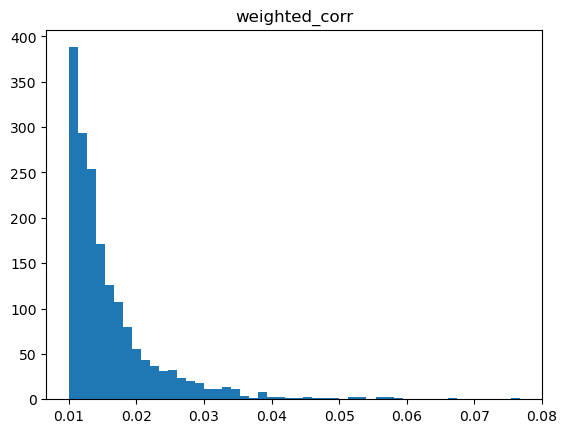

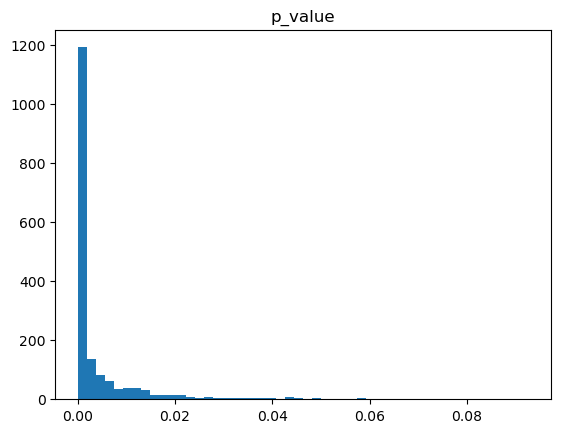

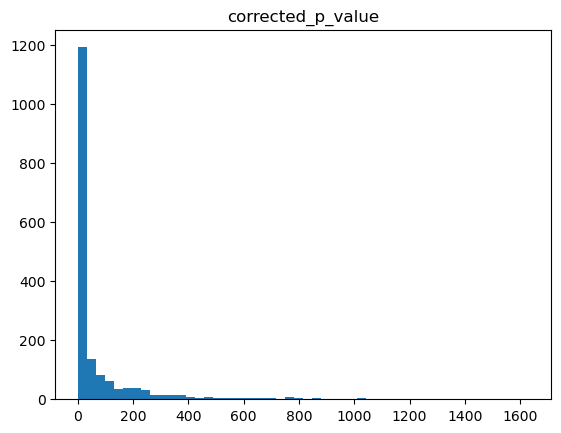

In [130]:
selected_genes = []
not_selected_genes = []
x = {}
for gene in gene_corr:
    for key in gene_corr[gene]:
        x[key] = []

    break

for gene in gene_corr:
    if gene_corr[gene]['weighted_corr'] > 0.01:
        selected_genes.append(gene)
        for key in x:
            x[key].append(gene_corr[gene][key])
    else:
        not_selected_genes.append(gene)

print(f'# selected genes = {len(selected_genes)}')

for key in x:
    plt.figure()
    plt.title(key)
    plt.hist(x[key], bins=50)

plt.show()

# selected genes = 337


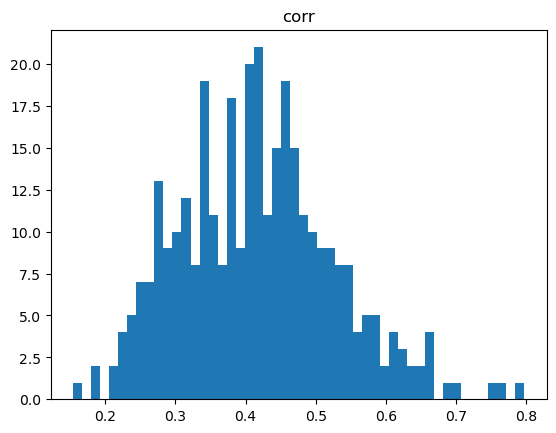

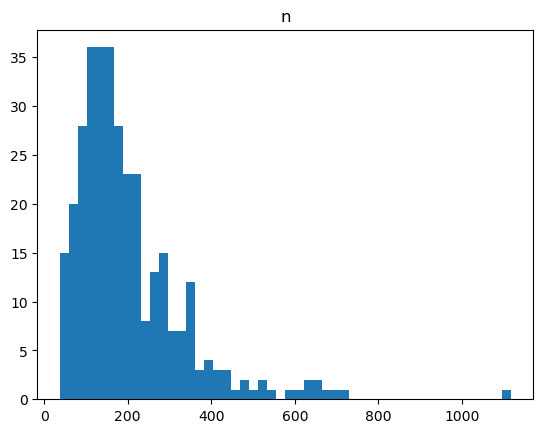

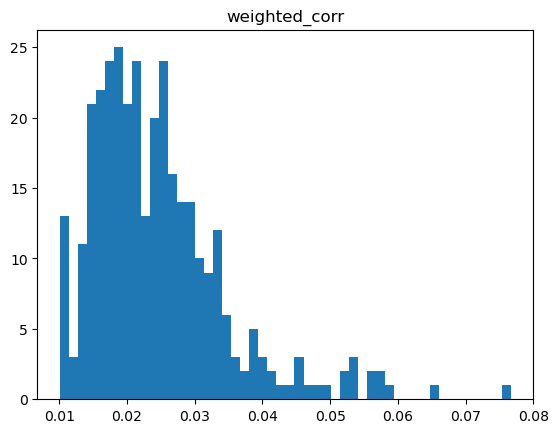

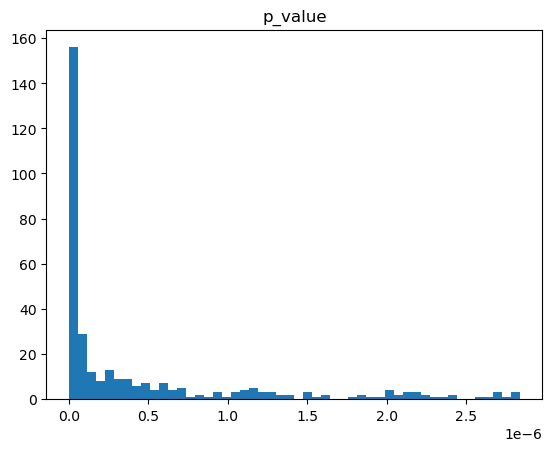

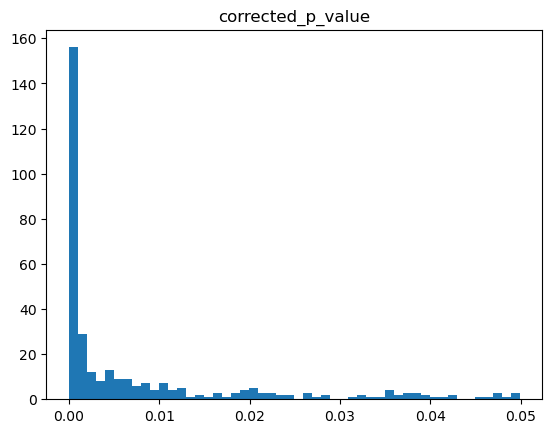

In [124]:
# selected_genes = []
# not_selected_genes = []
# x = {}
# for gene in gene_corr:
#     for key in gene_corr[gene]:
#         x[key] = []

#     break

# for gene in gene_corr:
#     if gene_corr[gene]['corrected_p_value'] < 0.05:
#         selected_genes.append(gene)
#         for key in x:
#             x[key].append(gene_corr[gene][key])
#     else:
#         not_selected_genes.append(gene)

# print(f'# selected genes = {len(selected_genes)}')

# for key in x:
#     plt.figure()
#     plt.title(key)
#     plt.hist(x[key], bins=50)

# plt.show()

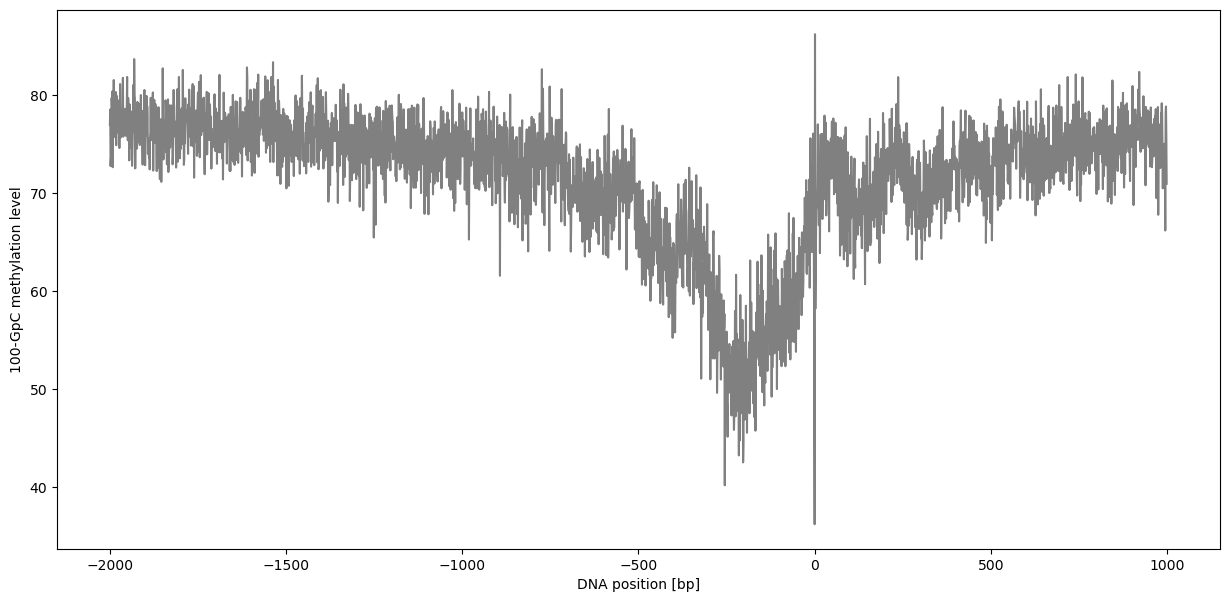

In [131]:
plot_avg_methylation_levels(df, 'GCH', select_genes=selected_genes)

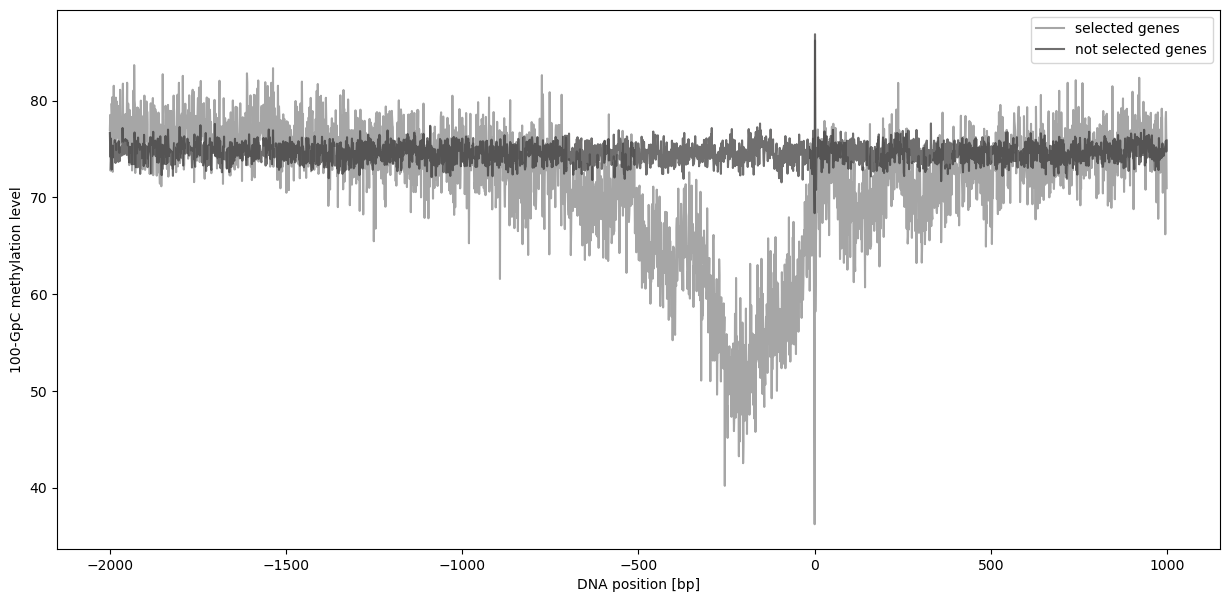

In [132]:
plot_avg_methylation_levels(df, 'GCH', select_genes=selected_genes, fig = True, c = 'grey', label = 'selected genes')
plot_avg_methylation_levels(df, 'GCH', select_genes=not_selected_genes, fig = False, c = '#333232', label = 'not selected genes')

In [133]:
# outfile = data_path + 'selected_genes_introns.txt'
# with open(outfile, 'w') as fout:
#     for gene in selected_genes:
#         fout.write(gene + '\n')

Filter out the pos of introns for the selected genes

In [136]:
'''
    Write out selection annotations into bed file
'''
# infile = data_path + 'refGene.introns.anchor_start.sorted.bed'
# outfile = data_path + 'refGene.introns.anchor_start.sorted.selection.bed'
# with open(outfile, 'w') as fout:
#     with open(infile, 'r') as fin: 
#         for line in fin:
#             line_s = line.strip().split('\t')
#             gene = line_s[4]

#             if gene in selected_genes:
#                 fout.write(line)

GCH intersection and profile on selection \
Should have the same profile as before - sanity check

In [137]:
# # GCH intersect with promoter

# promoters_sorted = data_path + 'refGene.introns.anchor_start.sorted.selection.bed'
# gch_sorted = data_path + 'GCH.filtered.sorted.bed'
# outfile = data_path + 'GCH.introns.intersect.selection.bed'

# nome.intersect_bed(promoters_sorted, gch_sorted, outfile)

error in intersect


In [143]:
infile = data_path + 'GCH.introns.intersect.selection.bed'
df = get_intron_methylation(infile)

In [144]:
df.head()

,trans_id,refid,gene_name,chrom,intron_start,intron_end,TSS,TES,strand,meth_start_genome,meth_end_genome,meth_pos_intron_abs,meth_pos_intron_rel,meth_rate,coverage
0,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549042,1549043,29,-1971,66.67,3
1,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549043,1549044,30,-1970,0.00,5
2,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549048,1549049,35,-1965,66.67,3
3,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549049,1549050,36,-1964,0.00,5
4,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549051,1549052,38,-1962,66.67,3


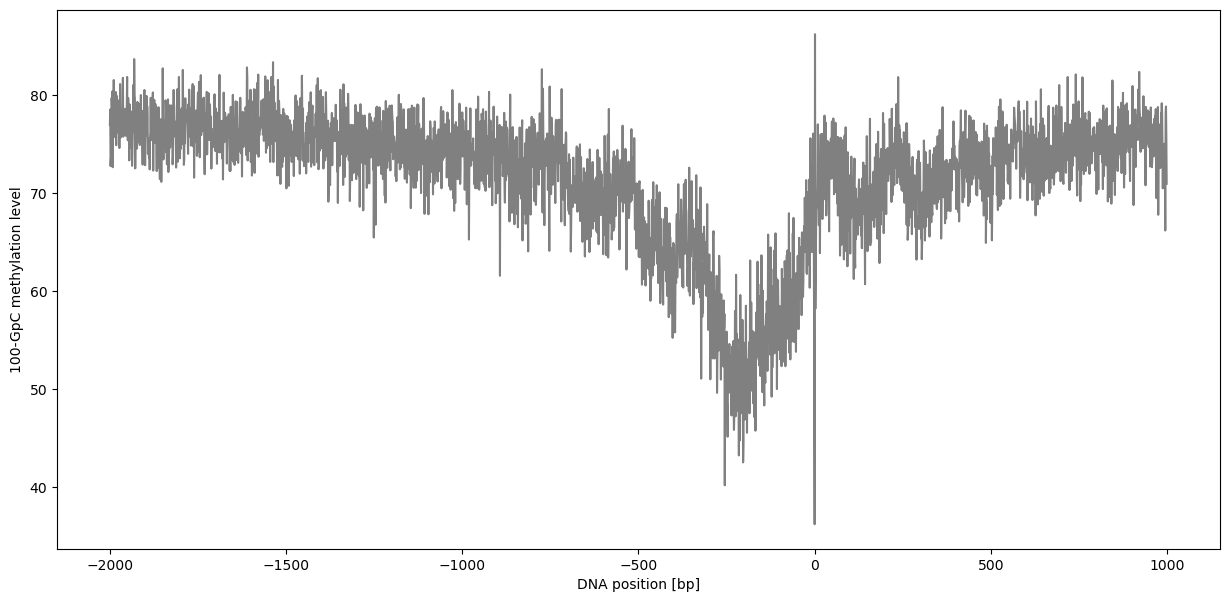

In [145]:
plot_avg_methylation_levels(df, 'GCH')

In [168]:
# # HCG intersect with promoter

# introns_sorted = data_path + 'refGene.introns.anchor_start.sorted.bed'
# hcg_sorted = data_path + 'HCG.filtered.sorted.bed'
# outfile = data_path + 'HCG.introns.intersect.bed'

# nome.intersect_bed(introns_sorted, hcg_sorted, outfile)

In [169]:
infile = data_path + 'HCG.introns.intersect.bed'
df = get_intron_methylation(infile)

In [170]:
df.head()

,trans_id,refid,gene_name,chrom,intron_start,intron_end,TSS,TES,strand,meth_start_genome,meth_end_genome,meth_pos_intron_abs,meth_pos_intron_rel,meth_rate,coverage
0,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858547,858548,219,-1781,0.00,3
1,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858558,858559,230,-1770,0.00,3
2,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858598,858599,270,-1730,0.00,3
3,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858790,858791,462,-1538,42.86,7
4,NM_001385640-858328,NM_001385640,SAMD11,chr1,858328,861328,859302,879954,+,858820,858821,492,-1508,0.00,5


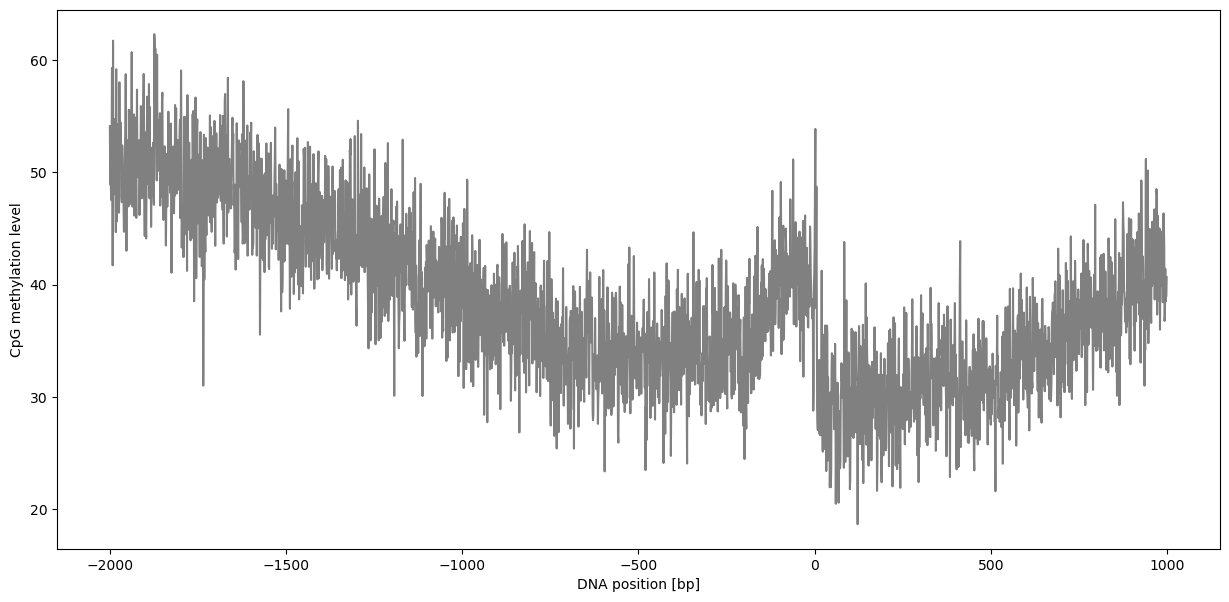

In [171]:
plot_avg_methylation_levels(df, 'HCG')

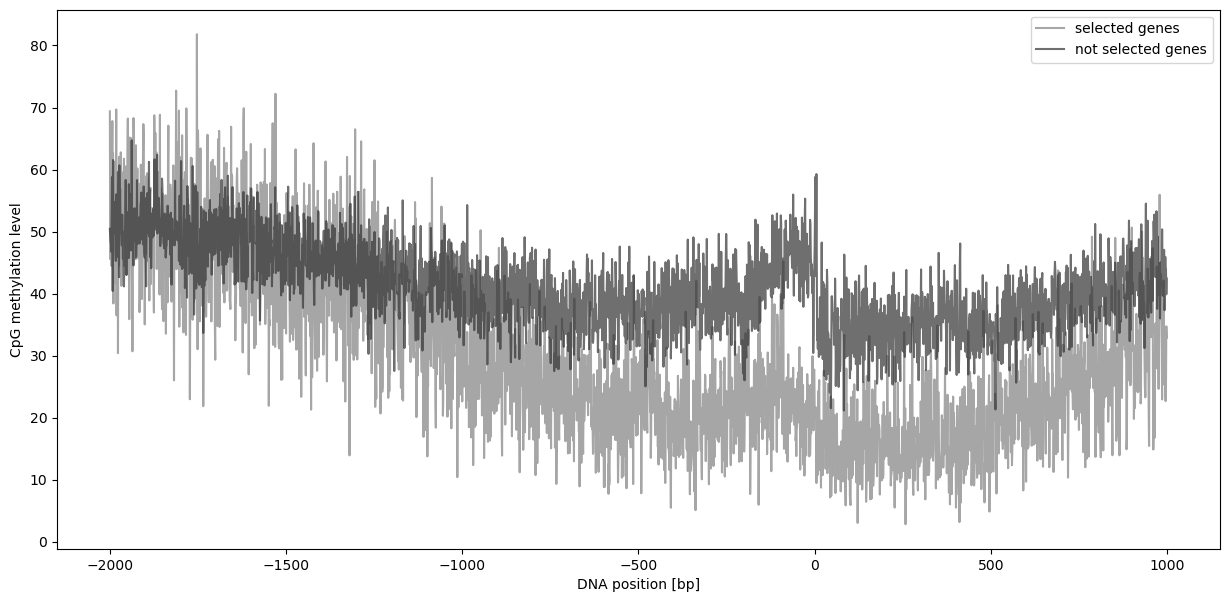

In [173]:
plot_avg_methylation_levels(df, 'HCG', select_genes=selected_genes, fig = True, c = 'grey', label = 'selected genes')
plot_avg_methylation_levels(df, 'HCG', select_genes=not_selected_genes, fig = False, c = '#333232', label = 'not selected genes')

We have a good profile in the not selected set - What should we focus on when we do selection

HCG intersection and profile on selection

In [141]:
# # HCG intersect with promoter

# introns_sorted = data_path + 'refGene.introns.anchor_start.sorted.selection.bed'
# hcg_sorted = data_path + 'HCG.filtered.sorted.bed'
# outfile = data_path + 'HCG.introns.intersect.selection.bed'

# nome.intersect_bed(introns_sorted, hcg_sorted, outfile)

error in intersect


In [160]:
infile = data_path + 'HCG.introns.intersect.selection.bed'
df = get_intron_methylation(infile)

In [161]:
df.head()

,trans_id,refid,gene_name,chrom,intron_start,intron_end,TSS,TES,strand,meth_start_genome,meth_end_genome,meth_pos_intron_abs,meth_pos_intron_rel,meth_rate,coverage
0,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549165,1549166,152,-1848,100.0,3
1,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549166,1549167,153,-1847,100.0,3
2,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549234,1549235,221,-1779,100.0,3
3,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549280,1549281,267,-1733,100.0,5
4,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549307,1549308,294,-1706,80.0,5


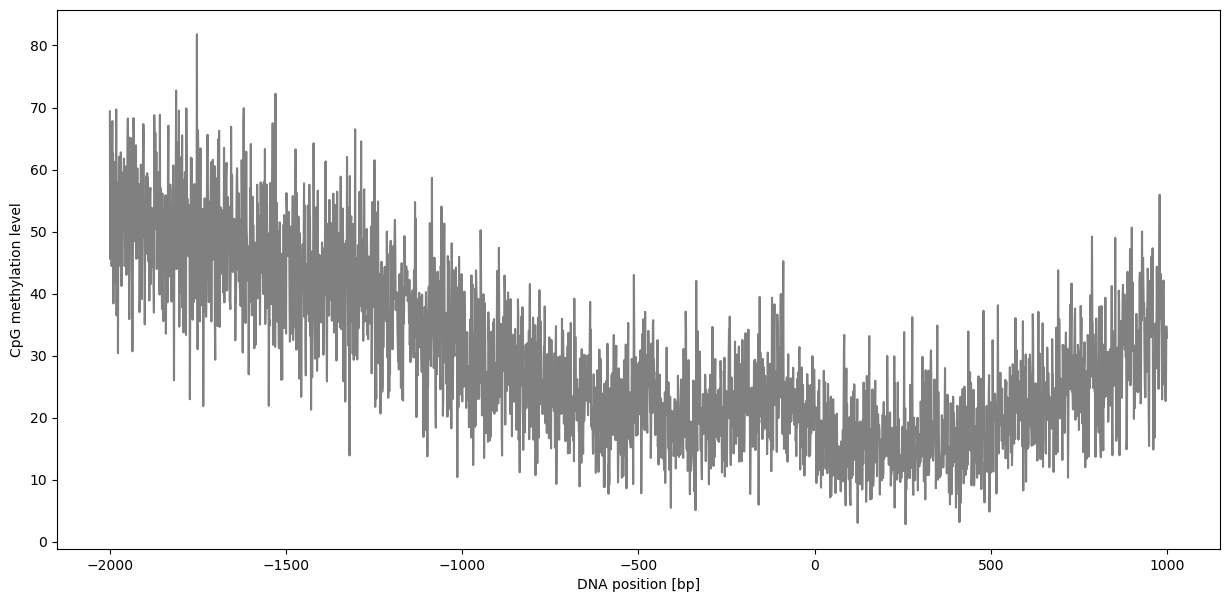

In [162]:
plot_avg_methylation_levels(df, 'HCG')

In [163]:
# df_random = df.copy()
# df_random['meth_rate'] = df_random['meth_rate'].sample(frac=1).reset_index(drop=True)

In [164]:
# outfile = data_path + 'HCG.random.introns.intersect.selection.bed'
# cols = ['chrom', 'intron_start', 'intron_end', 'refid', 'gene_name', 'TSS', 'TES', 'strand', 'chrom', 'meth_start_genome', 'meth_end_genome', 'strand', 'meth_rate', 'coverage']
# df_random[cols].to_csv(outfile, sep='\t', header=False, index=False)

In [165]:
infile = data_path + 'HCG.random.introns.intersect.selection.bed'
df_random = get_intron_methylation(infile)

In [166]:
df_random.head()

,trans_id,refid,gene_name,chrom,intron_start,intron_end,TSS,TES,strand,meth_start_genome,meth_end_genome,meth_pos_intron_abs,meth_pos_intron_rel,meth_rate,coverage
0,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549165,1549166,152,-1848,0.00,3
1,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549166,1549167,153,-1847,0.00,3
2,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549234,1549235,221,-1779,33.33,3
3,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549280,1549281,267,-1733,0.00,5
4,NM_001170688-1549013,NM_001170688,MIB2,chr1,1549013,1552013,1550794,1565990,+,1549307,1549308,294,-1706,0.00,5


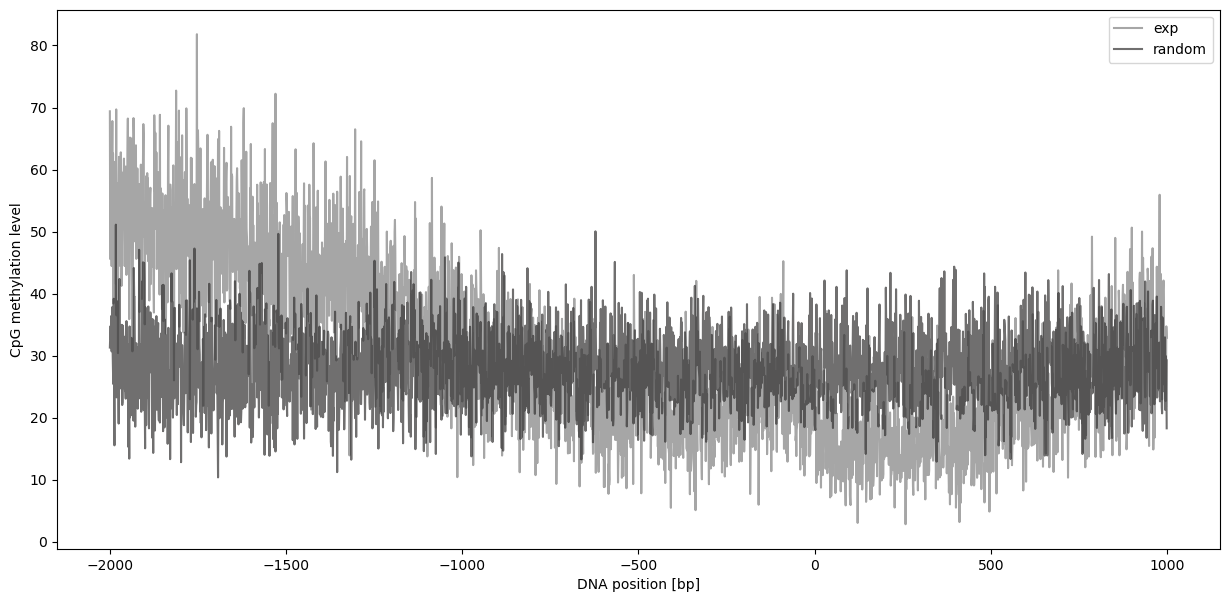

In [167]:
plot_avg_methylation_levels(df, 'HCG', label='exp')
plot_avg_methylation_levels(df_random, 'HCG', fig=False, c='#333232', label='random')